**Computer Lab: Natural Language Processing**

**SD-TSIA 211**

**Tikhonov regularization**

**Question 3.1**
Calculate the gradient of f1 and its Hessian matrix. Is the function convex?

$$f_1 : (w_0, w) \mapsto \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-y_i(x_i^T w + w_0))) + \frac{\rho}{2} \|w\|_2^2$$

Let $\tilde{w} = (w, w_0)^T$ and $\tilde{x_i} = (x_i, 1)^T$ for all $i$. Then

$$f_1 : \tilde{w} \mapsto \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-y_i(\tilde{x_i}^T \tilde{w}))) + \frac{\rho}{2} \|\tilde{w}\|_2^2$$

$$\nabla f_1(\tilde{w}) = \frac{1}{n} \sum_{i=1}^{n} \dfrac{-y_i \tilde{x_i} \exp(-y_i \tilde{x_i}^T \tilde{w})}{1 + \exp(-y_i \tilde{x_i}^T \tilde{w})} + \rho \tilde{w}\$$

and

$$\nabla^2 f_1(\tilde{w}) = \frac{1}{n} \sum_{i=1}^{n} \dfrac{\exp(-y_i \tilde{x_i}^T \tilde{w})}{\left(1 + \exp(-y_i \tilde{x_i}^T \tilde{w})\right)^2} \tilde{x_i} \tilde{x_i}^T + \rho I_{p+1}$$

The hessian matrix is a positive definite matrix: the 1st term is a semi-definite positive matrix. We suppose that $\rho$ is positive, so adding $\rho I_{p+1}$ ensures that all the eigenvalues are  positive. Thus, $f_1$ is convex.

<hr style="border: 1px solid black"></hr>





**Question 3.2**
Code a function that returns the value of f1, its gradient and Hessian matrix.
Please use the dataset described in Section 1 and ρ = 1/n. It may be convenient to add
a column of ones to the matrix X.
Test your computations using the function check grad on a small-dimensional problem

In [1]:
import numpy as np
from scipy.optimize import check_grad

import matplotlib.pyplot as plt

import tp_reglog_utils

`wtilde = (w, w0)`

`wtilde.shape = (p+1,)`

In [2]:
p = 10 # dimension
n = 5  # number of observations

In [3]:
def f1(wtilde):
    rho = 1/n
    sum = 0
    for i in range(n):
        sum += np.log(1 + np.exp(-y[i] * xtilde[i].T @ wtilde)) / n
    sum += rho/2 * np.linalg.norm(wtilde[:-1], 2)**2
    return sum

In [4]:
def grad_f1(wtilde):
    rho = 1/n
    sum = 0
    for i in range(n):
        sum += -y[i] * np.exp(-y[i] * xtilde[i].T @ wtilde) * xtilde[i] / (1 + np.exp(-y[i] * xtilde[i].T @ wtilde)) / n
    sum += rho * np.concatenate((wtilde[:-1], [0]))
    return sum

In [5]:
def hess_f1(wtilde):
    rho = 1/n
    sum = 0
    for i in range(n):
        sum += (np.exp(-y[i] * xtilde[i].T @ wtilde) / (1 + np.exp(-y[i] * xtilde[i].T @ wtilde))**2 
                * np.outer(xtilde[i], xtilde[i].T) / n)
    sum += rho * np.eye(p+1)
    return sum

Let's test grad_f1 and hess_f1 on a small-dimensional problem


In [6]:
n, p = 10, 20

x = np.random.rand(n, p)
xtilde = np.hstack((x, np.ones((x.shape[0], 1))))
y = np.random.choice([-1, 1], n)

BATCH_SIZE = 100
np.max([check_grad(f1, grad_f1, np.random.standard_normal(p+1)) for _ in range(BATCH_SIZE)])

2.665762469969113e-07

Now, let's test these functions with our train dataset ($n = 10000$, $p = 575$)

In [7]:
eX, y, eX_test, y_test = tp_reglog_utils.load_data()

n, p = eX.shape[0], eX.shape[1]-1
x = eX
xtilde = np.roll(x, -1, axis=1)

check_grad(f1, grad_f1, np.random.rand(p+1))

3.5454478168335354e-05

For both cases, the square root of the sum of squares of the difference between the gradient and its finite difference approximation is very small. We can say then, that the formulas and computations are coherent.

In [8]:
def check_hess(grad_func, hess_func, x0):
    return check_grad(lambda x: grad_func(x)[0], lambda x: hess_func(x)[:,0], x0)

In [9]:
check_hess(grad_f1, hess_f1, np.random.rand(p+1))

KeyboardInterrupt: 

The hess_f1 function is also coherent.

<hr style="border: 1px solid black"></hr>

**Question 3.3** 

For Armijo's line search, $0<a<1$ and $b=1$ so that $b a^0 = 1$ and we can directly use the unit step size at the first try if it suits to the condition (to keep the quadratic convergence).

In [18]:
def armijo_newton(x, grad, hess, d, a, b):
    l = 0
    gamma = b*a**l
    while f1(x-gamma*d) > f1(x) - gamma * grad @ d + gamma/2 * d.T @ hess @ d:
        l += 1
        gamma = b*a**l        
    return l

In [19]:
def newton(initial, max_iter=100, eps=1e-10, armijo=True, verbose=False):
    a, b = 0.5, 1 # We use Armijo rule with this method
    wtilde = initial
    grad_norms, values = [], []
    norm = np.linalg.norm(grad_f1(wtilde), 2)
    grad_norms.append(norm)
    n = 0
    while (norm > eps) & (n < max_iter):
        grad = grad_f1(wtilde)
        hess = hess_f1(wtilde)
        d = np.linalg.inv(hess) @ grad
        if (armijo):
            l = armijo_newton(wtilde, grad, hess, d, a, b)
            wtilde -= b*a**l*d
        else:
            l = 1
            wtilde -= d
        norm = np.linalg.norm(grad_f1(wtilde), 2) 
        grad_norms.append(norm)
        values.append(f1(wtilde))
        n += 1
        if (verbose):
            print(f"step={n}: l={l}, f1={values[-1]}, norm={norm}")
    return wtilde, grad_norms, values

In [20]:
eX, y, eX_test, y_test = tp_reglog_utils.load_data()

n, p = eX.shape[0], eX.shape[1]-1
x = eX
xtilde = np.roll(x, -1, axis=1)

In [21]:
init = np.zeros(p+1)
wtilde_opt, grad_norms, values = newton(init, max_iter=10, armijo=False)

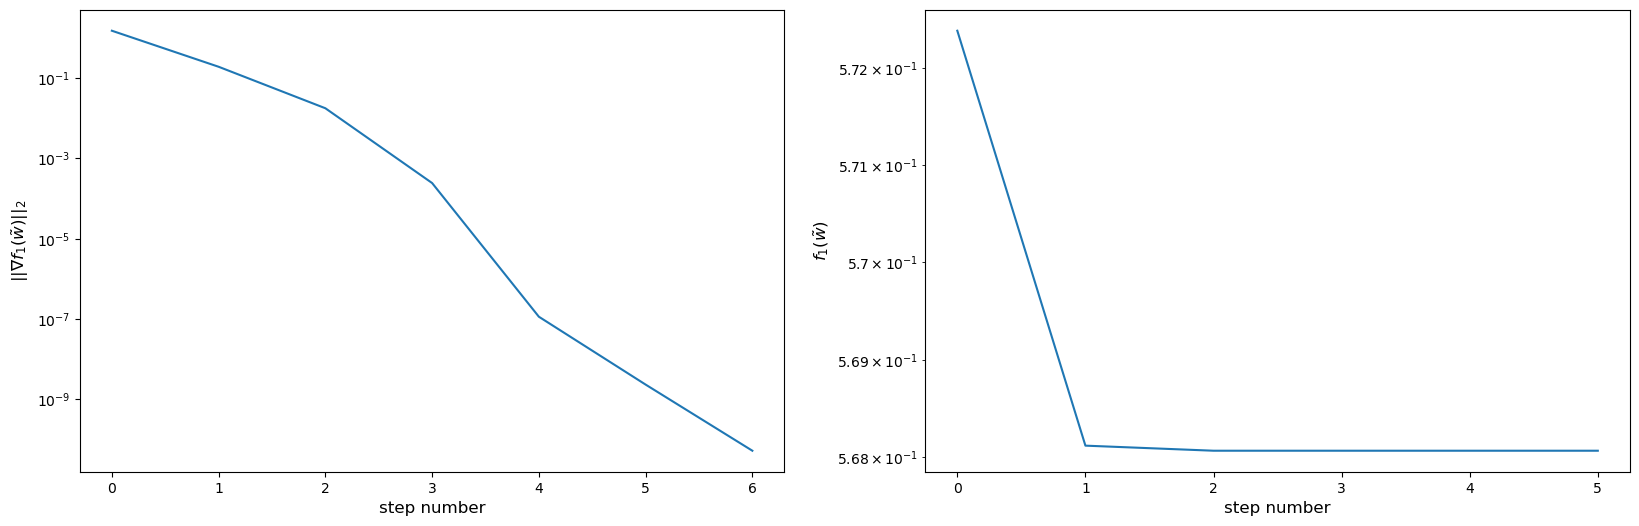

In [22]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 6))

ax0.plot(grad_norms)
ax0.set_yscale("log")
ax0.set_xlabel("step number", fontsize=12)
ax0.set_ylabel(r"$\|\| \nabla f_1(\tilde{w}) \|\|_2$", fontsize=12)

ax1.plot(values)
ax1.set_yscale("log")
ax1.set_xlabel("step number", fontsize=12)
ax1.set_ylabel(r"$f_1(\tilde{w})$", fontsize=12)

plt.show()

The algorithm converges very quickly towards a minimizer.

In [23]:
f1(wtilde_opt)

0.568066887986378

<hr style="border: 1px solid black"></hr>

**Questions 3.4 & 3.5**
(We already used armijo line search with newton methos in question 3.3)

In [24]:
eX, y, eX_test, y_test = tp_reglog_utils.load_data()

n, p = eX.shape[0], eX.shape[1]-1
x = eX
xtilde = np.roll(x, -1, axis=1)

C:\Users\raiss-22\AppData\Local\Temp\ipykernel_11636\3060364201.py:5: RuntimeWarning: overflow encountered in exp
  sum += np.log(1 + np.exp(-y[i] * xtilde[i].T @ wtilde)) / n


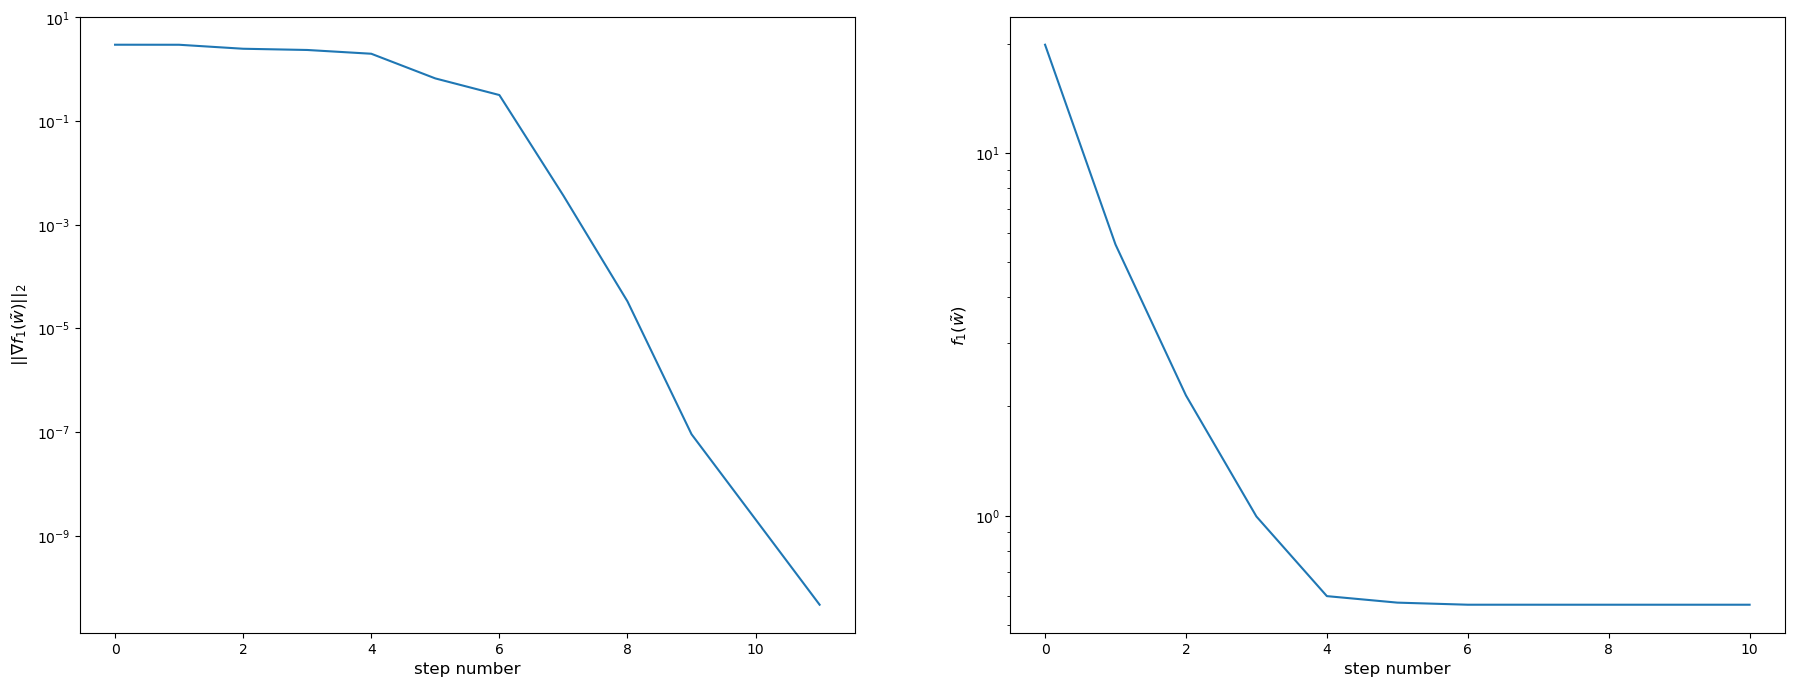

In [25]:
init = np.full(p+1, 1.)
wtilde_opt, grad_norms, values = newton(init)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))

ax0.plot(grad_norms)
ax0.set_yscale("log")
ax0.set_xlabel("step number", fontsize=12)
ax0.set_ylabel(r"$\|\| \nabla f_1(\tilde{w}) \|\|_2$", fontsize=12)

ax1.plot(values)
ax1.set_yscale("log")
ax1.set_xlabel("step number", fontsize=12)
ax1.set_ylabel(r"$f_1(\tilde{w})$", fontsize=12)

plt.show()

In [26]:
f1(wtilde_opt)

0.5680668879863771

It takes its time... This surely is less efficient than starting from a point near the minimizer.

***Regularization for sparse model***


**Question 4.1** : Since the $ \| \cdot \|_1$ isn't a $\mathscr{C}^1$ function, $F_2$ is not $\mathscr{C}^3$ hence Newton's method cannot be applied.

**Question 4.2** : 
$F_2 = f_2 + g_2$ with 

$$f_2 : (w_0, w) \mapsto \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-y_i(x_i^T w + w_0)))$$

$$ g_2 : (w_0,w) \mapsto   \rho \|w\|_1$$

$$ \mathrm{prox}_{g_2}(x) = \mathrm{argmin}_{y \in \mathbb{R}^p}  \ {g_2(y) + \frac{1}{2} \| y -x \|^2 } 
= \Big(\mathrm{sgn}(x_i) \max(|x_i| - \rho,0)\Big)_{i\in \{1,...,p\} } $$

As previously calculated,

$$ \nabla f_2(\tilde{w}) = \frac{1}{n} \sum_{i=1}^{n} \dfrac{-y_i \tilde{x_i} \exp(-y_i \tilde{x_i}^T \tilde{w})}{1 + \exp(-y_i \tilde{x_i}^T \tilde{w})}$$

<hr style="border: 1px solid black"></hr>

**Question 4.3**

In [30]:
def f2(wtilde):
    sum = 0
    for i in range(n):
        sum += np.log(1 + np.exp(-y[i] * xtilde[i].T @ wtilde)) / n
    return sum

In [31]:
def F2(wtilde, rho):
    return f2(wtilde) + rho*np.linalg.norm(wtilde[:-1], 1)

In [32]:
def grad_f2(wtilde):
    sum = 0
    for i in range(n):
        sum += -y[i] * np.exp(-y[i] * xtilde[i].T @ wtilde) * xtilde[i] / (1 + np.exp(-y[i] * xtilde[i].T @ wtilde))
    return sum / n

In [33]:
def grad_f2(wtilde):
    sum = 0
    for i in range(n):
        sum += -y[i] * np.exp(-y[i] * xtilde[i].T @ wtilde) * xtilde[i] / (1 + np.exp(-y[i] * xtilde[i].T @ wtilde))
    return sum / n

In [34]:
check_grad(f2, grad_f2, np.random.rand(p+1))

3.377516577538404e-05

In [35]:
def prox_norm1(wtilde, alpha):
    return np.sign(wtilde) * np.maximum(np.abs(wtilde) - alpha, 0)

In [36]:
def find_gamma(wtilde, grad, rho, a, b):
    l = 0
    gamma = b*a**l
    wtildeplus = prox_norm1(wtilde - gamma*grad, gamma*rho)
    while (f2(wtildeplus) >
           f2(wtilde) + (grad @ (wtildeplus - wtilde)) + np.linalg.norm(wtilde - wtildeplus, 2)**2/(2*gamma)) :
        l += 1
        gamma = b*a**l
        wtildeplus = prox_norm1(wtilde - gamma*grad, gamma*rho)
    return gamma

In [37]:
def optimal_F2_subgrad(wtilde, rho=0.02):
    grad = grad_f2(wtilde)
    subgrad = np.zeros(p+1)
    for i in range(p+1):
        subgrad[i] = grad[i] + rho*np.sign(wtilde[i])
        if (np.sign(wtilde[i]) == 0):
            subgrad[i] = prox_norm1(grad[i], rho)
    return subgrad

In [38]:
def prox_gradient(initial, max_iter=100, eps=1e-5, rho=0.02, verbose=False):
    a, b = 0.5, 1 # to find gamma
    wtilde = initial
    grad_norms, values = [], []
    norm = np.linalg.norm(optimal_F2_subgrad(wtilde), 2)
    grad_norms.append(norm)
    n = 0
    while (norm > eps) & (n < max_iter):
        grad = grad_f2(wtilde)
        gamma = find_gamma(wtilde, grad, rho, a, b)
        wtilde = prox_norm1(wtilde - gamma*grad, rho*gamma)
        norm = np.linalg.norm(optimal_F2_subgrad(wtilde), 2)
        grad_norms.append(norm)
        values.append(F2(wtilde, rho))
        n += 1
        if (verbose):
            print(f"step={n}: gamma={gamma}, F2={values[-1]}, norm={norm}")
    return wtilde, grad_norms, values

In [39]:
init = np.zeros(p+1)
wtilde_opt, grad_norms, values = prox_gradient(init)

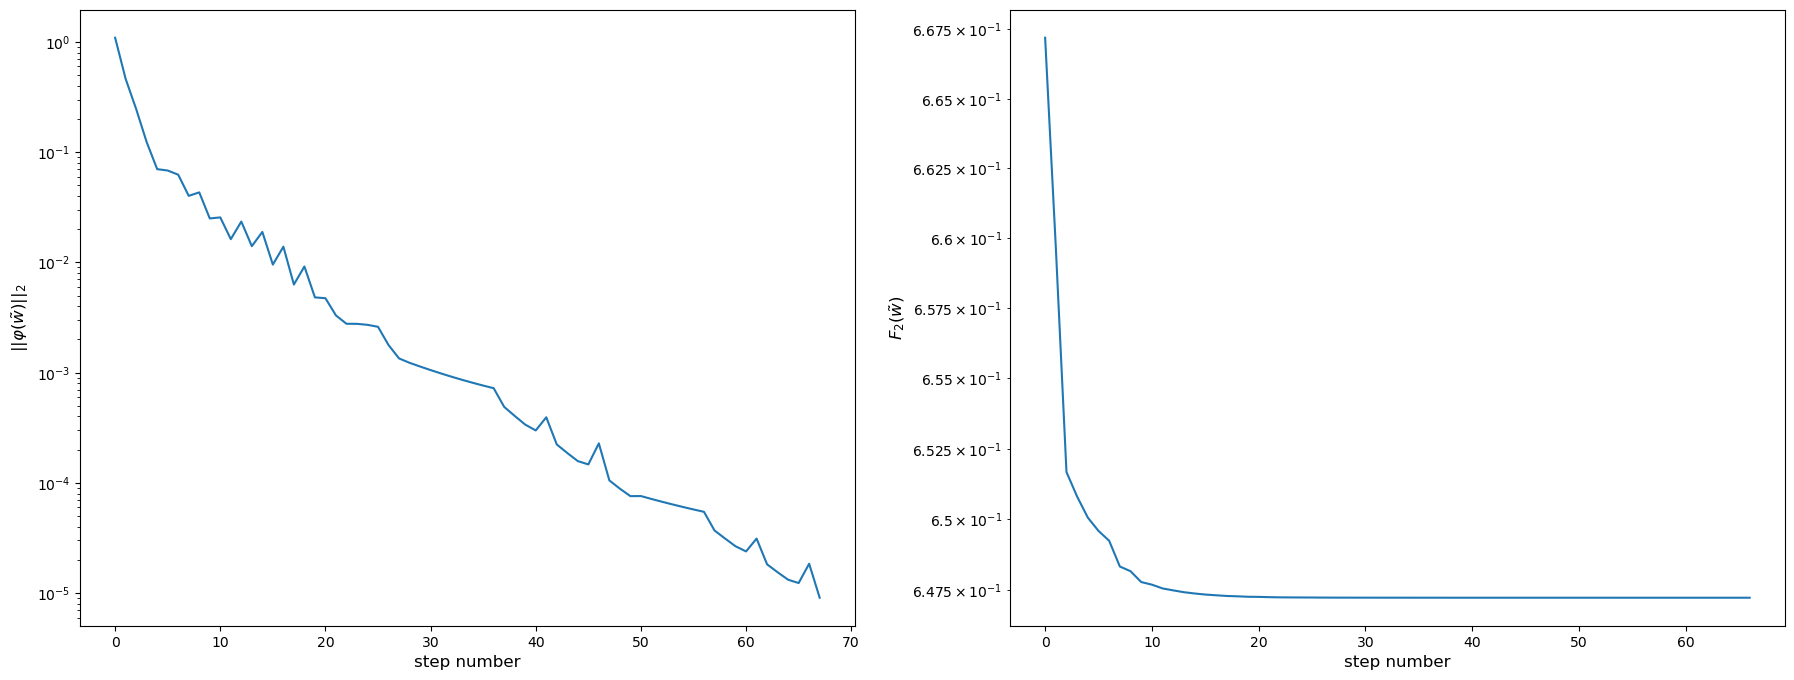

In [40]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(22, 8))

ax0.plot(grad_norms)
ax0.set_yscale("log")
ax0.set_xlabel("step number", fontsize=12)
ax0.set_ylabel(r"$\|\| \varphi(\tilde{w}) \|\|_2$", fontsize=12)

ax1.plot(values)
ax1.set_yscale("log")
ax1.set_xlabel("step number", fontsize=12)
ax1.set_ylabel(r"$F_2(\tilde{w})$", fontsize=12)

plt.show()

In [41]:
F2(wtilde_opt, 0.02)

0.6472420378313435